In [ ]:
%matplotlib inline
from config_calc import *

import matplotlib
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'

import cmocean
import plot_tools

### read glodap data

In [2]:
glodap = {}
for f in ['BkgC14','CFC11','pCFC11','CFC12','pCFC12','BombC14','C14']:
    glodapi = xr.open_dataset('/glade/p/work/mclong/GLODAP/GLODAP_orig/%s.nc'%f)
    glodapi = glodapi.transpose('depth','latitude','longitude')    
    if glodap:
        glodap = xr.merge((glodap,glodapi))
    else:
        glodap = glodapi
        
glodap = glodap.rename({'latitude':'lat','longitude':'lon'})
glodap = glodap.sel(depth=slice(200,600))
glodap

<xarray.Dataset>
Dimensions:     (depth: 6, lat: 180, lon: 360)
Coordinates:
  * lon         (lon) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
  * lat         (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * depth       (depth) float64 200.0 250.0 300.0 400.0 500.0 600.0
Data variables:
    BkgC14      (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    BkgC14Err   (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    dz          (depth) float64 50.0 50.0 75.0 100.0 100.0 100.0
    CFC11       (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    CFC11Err    (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    pCFC11      (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    pCFC11Err   (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    CFC12       (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    CFC12Err    (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ..

### read woa data

In [3]:
woapth = '/glade/p/ncgd0033/obs/woa2013v2/1x1d'

woa_info = {
    'O2': {'varname': 'o_an', 'file' : os.path.join(woapth,'woa13_all_o00_01.nc')},   
    'O2sat': {'varname': 'O_an', 'file': os.path.join(woapth,'woa13_all_O00_01.nc')},
    'AOU': {'varname': 'A_an', 'file' : os.path.join(woapth,'woa13_all_A00_01.nc')},    
    'T' : {'varname': 't_an', 'file': os.path.join(woapth,'woa13_decav_t00_01v2.nc')},
    'S' : {'varname': 's_an', 'file': os.path.join(woapth,'woa13_decav_s00_01v2.nc')}}

woa = {}
for v,info in woa_info.items():   
    varname = info['varname']
    file_in = info['file']
    woai = xr.open_dataset(file_in,decode_times=False)
    woai = woai.drop([k for k in woai if k not in [varname,'lat','lon','depth','depth_bnds']])
    woai = woai.rename({varname:v})
    woai = woai.sel(depth=slice(200,600))
    if woa:
        woa = xr.merge((woa,woai))
    else:
        woa = woai
         
ni = len(woa.lon)
nj = len(woa.lat)

mlperl_2_mmolm3 = 1.e6 / 1.e3 / 22.3916
for v in ['O2','AOU']:
    woa[v] = woa[v] * mlperl_2_mmolm3
    woa[v].attrs['units'] = 'mmol m$^{-3}$'

woa['dz'] = woa.depth_bnds[:,1] - woa.depth_bnds[:,0]         
woa

<xarray.Dataset>
Dimensions:     (depth: 15, lat: 180, lon: 360, nbounds: 2, time: 1)
Coordinates:
  * lat         (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * lon         (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
  * depth       (depth) float32 200.0 225.0 250.0 275.0 300.0 325.0 350.0 ...
Dimensions without coordinates: nbounds, time
Data variables:
    depth_bnds  (depth, nbounds) float32 187.5 212.5 212.5 237.5 237.5 262.5 ...
    O2sat       (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    AOU         (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    S           (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    O2          (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    T           (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    dz          (depth) float32 25.0 25.0 25.0 25.0 25.0 25.0 25.0 25.0 25.0 ...

### compute thermocline mean: 200-600 m

In [4]:
%%time
nz = glodap.depth.shape[0]
nlat = glodap.lat.shape[0]
nlon = glodap.lon.shape[0]
zmask = xr.DataArray(np.ones(nz),dims='depth')

rmask = xr.DataArray(np.zeros((nz,nlat,nlon)),dims=('depth','lat','lon'))
rmask[:,:,:] = np.where(np.isnan(glodap.C14), 0., 1.)
print rmask

<xarray.DataArray (depth: 6, lat: 180, lon: 360)>
array([[[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]],

       [[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]],

       ..., 
       [[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]],

       [[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]]])
Dimensions without coordinates: depth, lat, lon
CPU times: user 11 ms, sys: 0 ns, total: 11 ms
Wall time: 9.95 ms


<xarray.DataArray (depth: 6, lat: 180, lon: 360)>
array([[[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       ..., 
       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]]])
Coordinates:
  * depth    (depth) float64 200.0 250.0 300.0 400.0 500.0 600.0
Dimensions without coordinates: lat, lon


/glade/p/work/mclong/miniconda2/lib/python2.7/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in divide
  if not reflexive


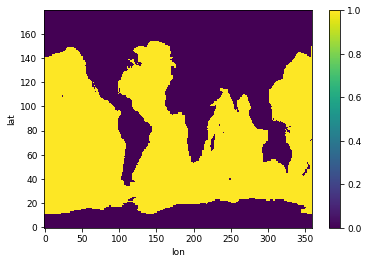

In [5]:
zwgt = (glodap.dz*rmask) / (glodap.dz*rmask).sum(dim='depth')
print zwgt
zwgt.sum(dim='depth').plot()

In [6]:
glodap_tc = (glodap*zwgt).sum(dim='depth')
glodap_tc = glodap_tc.where(zwgt.sum(dim='depth')>0)
glodap_tc.CFC11.dims

('lat', 'lon')

In [7]:
%%time
nz = woa.depth.shape[0]
nlat = woa.lat.shape[0]
nlon = woa.lon.shape[0]
zmask = xr.DataArray(np.ones(nz),dims='depth')

rmask = xr.DataArray(np.zeros((nz,nlat,nlon)),dims=('depth','lat','lon'))
rmask[:,:,:] = np.where(np.isnan(woa.O2), 0., 1.)
rmask

CPU times: user 10 ms, sys: 4 ms, total: 14 ms
Wall time: 14.1 ms


<xarray.Dataset>
Dimensions:     (depth: 15, lat: 180, lon: 360, nbounds: 2, time: 1)
Coordinates:
  * lat         (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * lon         (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
  * depth       (depth) float32 200.0 225.0 250.0 275.0 300.0 325.0 350.0 ...
Dimensions without coordinates: nbounds, time
Data variables:
    depth_bnds  (depth, nbounds) float32 187.5 212.5 212.5 237.5 237.5 262.5 ...
    O2sat       (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    AOU         (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    S           (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    O2          (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    T           (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    dz          (depth) float32 25.0 25.0 25.0 25.0 25.0 25.0 25.0 25.0 25.0 ...


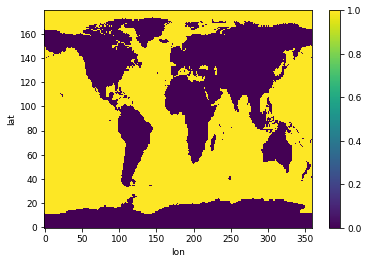

In [8]:
zwgt = (woa.dz*rmask) / (woa.dz*rmask).sum(dim='depth')
print woa
zwgt.sum(dim='depth').plot()

In [9]:
woa_tc = (woa*zwgt).sum(dim='depth').isel(time=0)
woa_tc = woa_tc.where(zwgt.sum(dim='depth')>0)
woa_tc

<xarray.Dataset>
Dimensions:     (lat: 180, lon: 360, nbounds: 2)
Coordinates:
  * lat         (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * lon         (lon) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
Dimensions without coordinates: nbounds
Data variables:
    depth_bnds  (nbounds, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    O2sat       (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    AOU         (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    S           (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    O2          (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    T           (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    dz          (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...

### make the plot

initial plot size (display units): 6.98,3.54
Adjusting fig size:
	(W,H in): 10.00,4.00 --> 8.03,6.73
new plot size: 5.61,3.57


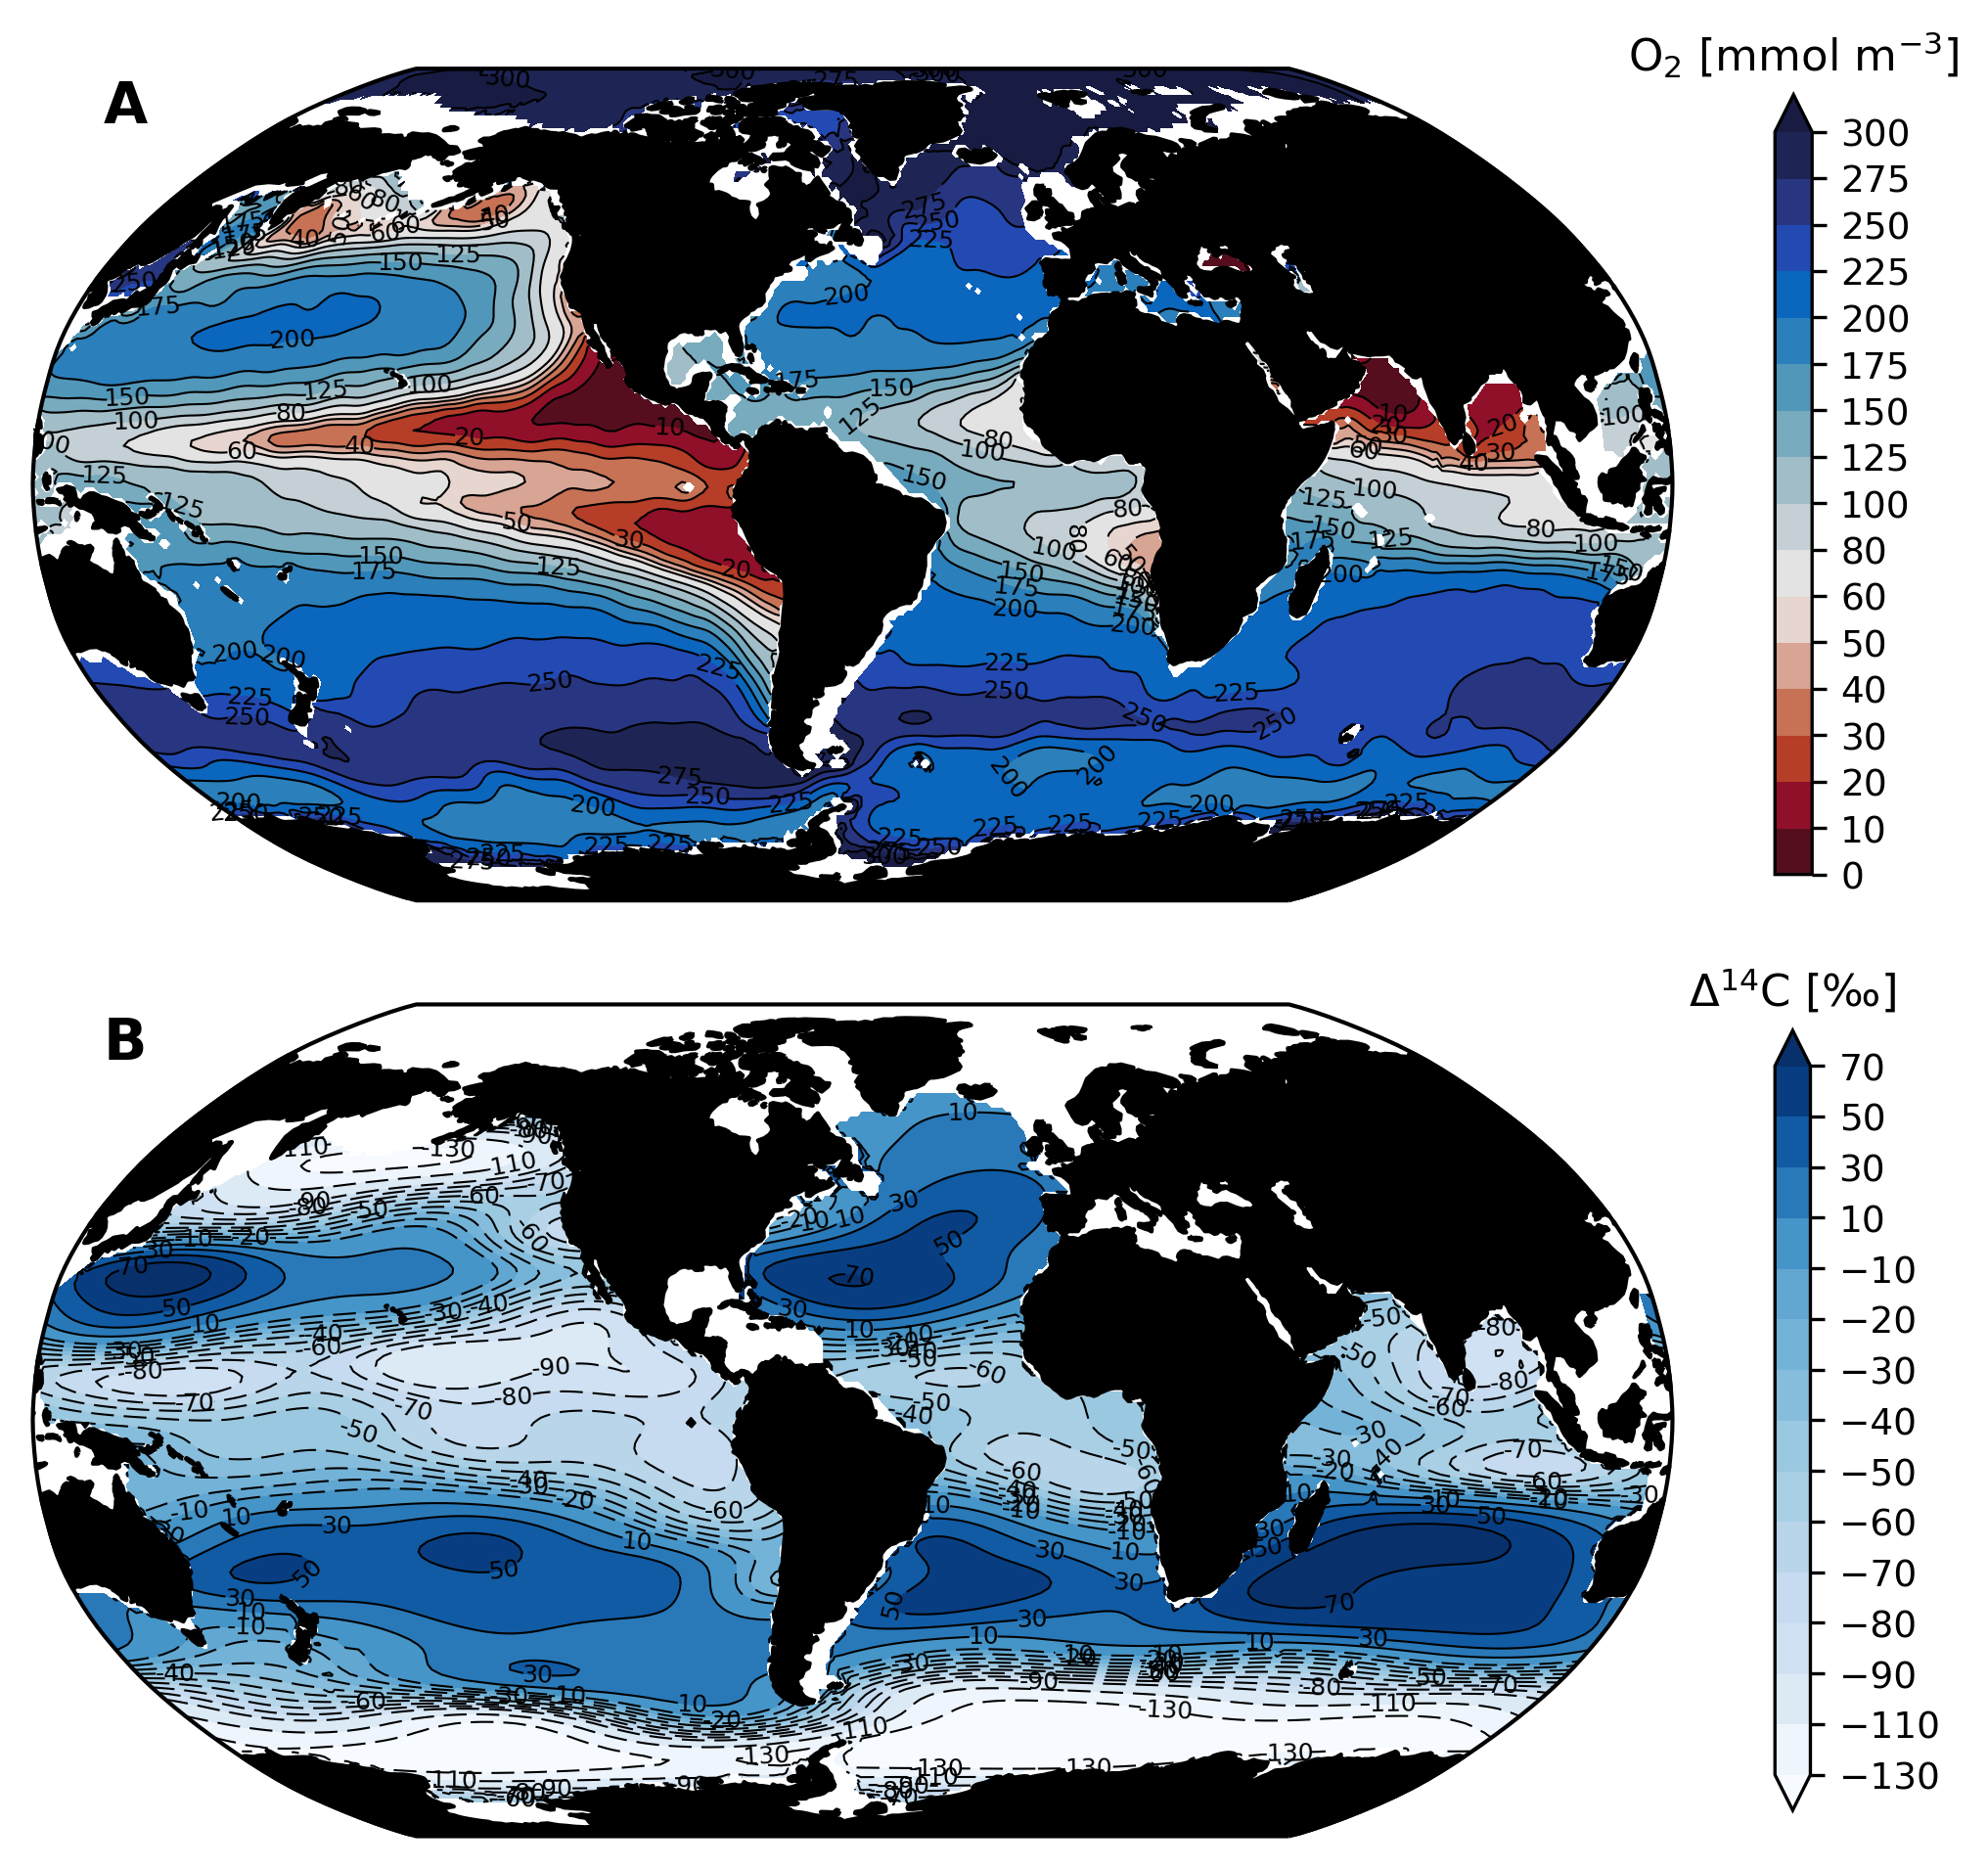

In [10]:
plot_name = os.path.join(diro['fig'],'woa-thermocline-o2-w-age_metric.pdf')

norm_o2 = plot_tools.MidPointNorm(midpoint=60.) 
norm_cfc = plot_tools.MidPointNorm(midpoint=30.) 
norm_c14 = plot_tools.MidPointNorm(midpoint=-20.) 
plots = {'O2' : 
         {'ds':woa_tc,
          'units' : 'O$_2$ [mmol m$^{-3}$]',
           'contour_specs': {'levels':[0,10,20,30,40,50,60,80,100,125,150,175,200,225,250,275,300],
                            'cmap':cmocean.cm.balance_r,
                            'norm':norm_o2,'extend':'max'}},
        'pCFC11' :
         {'ds':glodap_tc,
          'units' : 'pCFC-11 [patm]',
           'contour_specs': {'levels':[0.,10.,20.,30.,40.,50.,60.,80.,100.,125.,150.,175.,200.,225.],
                            'cmap':'Blues',
                            'norm':norm_o2,'extend':'max'}},
        'C14' :
         {'ds':glodap_tc,
          'units' : '$\Delta^{14}C$ ['+u'\u2030'+']',
           'contour_specs': {'levels':[-130,-110,-90,-80,-70,-60,-50,-40,-30,-20,-10,10,30,50,70],
                            'cmap':'Blues',
                            'norm':norm_c14,'extend':'both'}}}         

del plots['pCFC11']

matplotlib.rcParams['contour.negative_linestyle'] = 'dashed'

fig=plt.figure(figsize=(10, 4),dpi=300)
gs = gridspec.GridSpec(2,1)
       
obj = {}
ax = []
for i,(v,specs) in enumerate(plots.items()):
    ds_tc = specs['ds']
    units = specs['units']         
    contour_specs = specs['contour_specs']
          
    lat = ds_tc.lat.values
    lon = ds_tc.lon.values
    z = ds_tc[v].values

    lon = np.where(lon<0.,lon+360.,lon)
    I = np.argsort(lon)
    lon = lon[I]
    z = z[:,I]
    z,lon = add_cyclic_point(z,coord=lon)   
    lon[0] = lon[0]-1e-8
    
    obj[v] = plot_tools.canvas_map_contour_overlay(lon,lat,z,
                                                   contour_specs,
                                                   units = units,
                                                   fig=fig,
                                                   gridspec=gs,
                                                   row=i,col=0)
    ax.append(obj[v]['ax'])

gridspec_kwargs = {'hspace' : -0.1,
                   'wspace' : 0.05,
                   'left' : 0.,
                   'right' : 0.87,
                   'bottom' : 0.,
                   'top' : 1.}
fgsz = plot_tools.plotgrid(fig, gs, ax, [2,1],gridspec_kwargs)

alp = [chr(i).upper() for i in range(97,97+26)]
for i,axi in enumerate(ax):
    p = axi.get_position()
    y = p.y1-0.08
    fig.text(0.03,y,'%s'%alp[i],
             fontsize=14.,
             fontweight = 'semibold')
plt.savefig(plot_name,dpi=300,bbox_inches='tight')
          